# Ejemplo - Calibración de un modelo hidrológico

## Paso 1: Generar el modelo

<center><img src="HYMOD.png" width="700"/><center>    

### Importar librerías, elementos y algoritmos para construir el modelo

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.hymod import UpperZone, LinearReservoir
from superflexpy.implementation.elements.gr4j import InterceptionFilter, ProductionStore, RoutingStore, UnitHydrograph1, UnitHydrograph2, FluxAggregator
from superflexpy.implementation.elements.structure_elements import Junction, Splitter, Transparent
from superflexpy.framework.unit import Unit

### Generar modelo

In [4]:
def hymod(params, init):
    
    root_finder = PegasusPython()  # Use the default parameters
    numerical_approximation = ImplicitEulerPython(root_finder)

    upper_zone = UpperZone(parameters={'Smax': params['Smax'], 'm': params['m'], 'beta': params['beta']},
                           states={'S0': init['uz']},
                           approximation=numerical_approximation,
                           id='uz')

    splitter = Splitter(weight=[[params['alpha']], [1-params['alpha']]],
                        direction=[[0], [0]],
                        id='spl')

    channel_routing_1 = LinearReservoir(parameters={'k': params['k_ch1']},
                                        states={'S0': init['cr1']},
                                        approximation=numerical_approximation,
                                        id='cr1')

    channel_routing_2 = LinearReservoir(parameters={'k': params['k_ch2']},
                                        states={'S0': init['cr2']},
                                        approximation=numerical_approximation,
                                        id='cr2')

    channel_routing_3 = LinearReservoir(parameters={'k': params['k_ch3']},
                                        states={'S0': init['cr3']},
                                        approximation=numerical_approximation,
                                        id='cr3')

    lower_zone = LinearReservoir(parameters={'k': params['k_lz']},
                                 states={'S0': init['lz']},
                                 approximation=numerical_approximation,
                                 id='lz')

    transparent_1 = Transparent(id='tr1')

    transparent_2 = Transparent(id='tr2')

    junction = Junction(direction=[[0, 0]],  # First output
                        id='jun')

    model = Unit(layers=[[upper_zone],
                         [splitter],
                         [channel_routing_1, lower_zone],
                         [channel_routing_2, transparent_1],
                         [channel_routing_3, transparent_2],
                         [junction]],
                 id='model')
    
    return model

def gr4j(params, init):
    
    x1 = params['x1']
    x2 = params['x2']
    x3 = params['x3']
    x4 = params['x4']
    
    root_finder = PegasusPython()  # Use the default parameters
    numerical_approximation = ImplicitEulerPython(root_finder)
    
    interception_filter = InterceptionFilter(id='ir')
    production_store = ProductionStore(parameters={'x1': x1, 
                                                   'alpha': params['alpha'], 
                                                   'beta': params['beta'],
                                                   'ni': params['ni'],},
                                       states={'S0': init['ps']},
                                       approximation=numerical_approximation,
                                       id='ps')
    
    splitter = Splitter(weight=[[params['div']], [1-params['div']]],
                        direction=[[0], [0]],
                        id='spl')
    
    unit_hydrograph_1 = UnitHydrograph1(parameters={'lag-time': x4},
                                        states={'lag': None},
                                        id='uh1')

    unit_hydrograph_2 = UnitHydrograph2(parameters={'lag-time': 2*x4},
                                        states={'lag': None},
                                        id='uh2')
    
    routing_store = RoutingStore(parameters={'x2': x2, 
                                             'x3': x3,
                                             'gamma': params['gamma'], 
                                             'omega': params['omega']},
                                 states={'S0': init['rs']},
                                 approximation=numerical_approximation,
                                 id='rs')

    transparent = Transparent(id='tr')
    junction = Junction(direction=[[0, None],  # First output
                                   [1, None],  # Second output
                                   [None, 0]], # Third output
                        id='jun')
    
    flux_aggregator = FluxAggregator(id='fa')
    
    model = Unit(layers=[[interception_filter],
                         [production_store],
                         [splitter],
                         [unit_hydrograph_1, unit_hydrograph_2],
                         [routing_store, transparent],
                         [junction],
                         [flux_aggregator]],
                 id='model')
    
    return model

### Entradas y parámetros del modelo

In [100]:
# Read forcing data
data = np.loadtxt('data.csv', skiprows=1, delimiter=',')
P = data[:,0]
E = data[:,1]
obs = data[:,2]

A = 156 # Area (km2)

# Set parameters 
params = {'Smax':50.0,
          'm':-0.1,
          'beta':2.0,
          'alpha':0.8,
          'k_ch1':0.5,
          'k_ch2':0.5,
          'k_ch3':0.5,
          'k_lz':0.3}

init = {'uz':10.0,
        'cr1':10.0,
        'cr2':10.0,
        'cr3':10.0,
        'lz':10.0}

params_gr4j = {'x1':20.0,
               'x2':0.001,
               'x3':1000.0,
               'x4':1.0,
               'alpha':2.0,
               'beta':5.0,
               'gamma':5.0,
               'omega':3.5,
               'ni':4/9,
               'div':0.9}

init_gr4j = {'ps':10.0,
             'rs':10.0}

# Generate model
# model = hymod(params, init)
model = gr4j(params_gr4j, init_gr4j)

# Assign the input
# model.set_input([P, E]) # para hymod
model.set_input([E, P]) # para GR4J

# Set the timestep
model.set_timestep(1.0)

# Run the model
model.reset_states()
output = model.get_output()

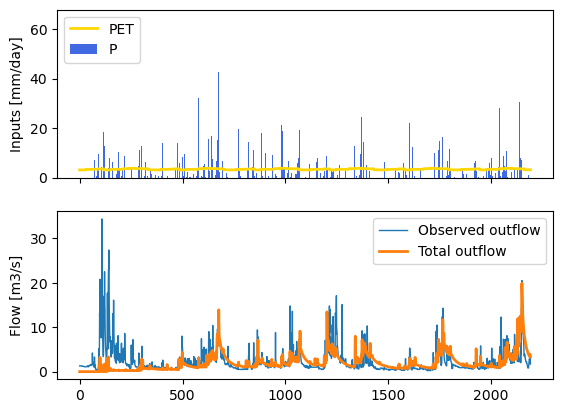

In [101]:
# Plot
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].bar(x=np.arange(len(P)), height=P, color='royalblue', label='P')
ax[0].plot(np.arange(len(P)), E, lw=2, color='gold', label='PET')
ax[0].legend()
ax[0].set_ylabel('Inputs [mm/day]')

ax[1].plot(np.arange(len(P)), obs, lw=1, label='Observed outflow')
ax[1].plot(np.arange(len(P)), output[0] * A * (1/(60*60*24)) * (1/1000) * (1000)**2, lw=2, label='Total outflow')
ax[1].legend()
ax[1].set_ylabel('Flow [m3/s]')

plt.show()

### Calibración

In [18]:
def rmse(obs, sim):
    res = obs - sim
    rmse = np.sqrt(res.dot(res)/len(res))
    return rmse

def nse(obs, sim):
    res = obs - sim
    res2 = obs - np.mean(obs)
    nse = 1 - res.dot(res)/res2.dot(res2)
    return nse

#### Hymod

In [77]:
# Calibration ranges
Smax_range = [10, 500]
beta_range = [0.1, 10]
alpha_range = [0, 1]
k_ch_range = [0.1, 2]
k_lz_range = [0, 0.1]
S0_range = [0, 10]

nsim = 5000 # Number of simulations
seed = 12345 # Random number seed
rng = np.random.default_rng(seed) # Random number generator

params = rng.uniform([Smax_range[0], beta_range[0], alpha_range[0], k_ch_range[0], k_lz_range[0], S0_range[0]],
                     [Smax_range[1], beta_range[1], alpha_range[1], k_ch_range[1], k_lz_range[1], S0_range[1]], 
                     (nsim, 6))

# Monte Carlo simulations
sim_out = []
obj_out = []
for i, param_i in enumerate(params):
    # update parameters
    param = {'Smax':param_i[0],
             'm':0.01,
             'beta':param_i[1],
             'alpha':param_i[2],
             'k_ch1':param_i[3],
             'k_ch2':param_i[3],
             'k_ch3':param_i[3],
             'k_lz':param_i[4]}

    init = {'uz':param_i[5],
            'cr1':param_i[5],
            'cr2':param_i[5],
            'cr3':param_i[5],
            'lz':param_i[5]}
    
    # set up and run model
    model = hymod(param, init)
    model.set_input([P, E])
    model.set_timestep(1.0), 
    model.reset_states()
    
    # compute performance metric
    try:
        sim_i = model.get_output()[0] * A * (1/(60*60*24)) * (1/1000) * (1000)**2
        obj_i = 1 - nse(obs, sim_i)
    
    except:
        sim_i = []
        obj_i = np.inf
    
    sim_out = sim_out + [sim_i]
    obj_out = obj_out + [obj_i]
    
sim_out = np.array(sim_out, dtype=object)
obj_out = np.array(obj_out)

best_obj = np.min(obj_out)
best_params = params[np.where(obj_out == best_obj)][0]

In [78]:
1 - best_obj

0.3831599239246529

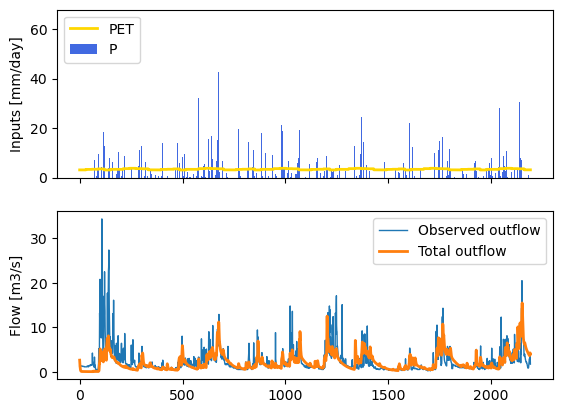

In [79]:
param = {'Smax':best_params[0],
         'm':0.01,
         'beta':best_params[1],
         'alpha':best_params[2],
         'k_ch1':best_params[3],
         'k_ch2':best_params[3],
         'k_ch3':best_params[3],
         'k_lz':best_params[4]}

init = {'uz':best_params[5],
        'cr1':best_params[5],
        'cr2':best_params[5],
        'cr3':best_params[5],
        'lz':best_params[5]}

# set up and run model
model = hymod(param, init)
model.set_input([P, E])
model.set_timestep(1.0), 
model.reset_states()

output = model.get_output()

# Plot
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].bar(x=np.arange(len(P)), height=P, color='royalblue', label='P')
ax[0].plot(np.arange(len(P)), E, lw=2, color='gold', label='PET')
ax[0].legend()
ax[0].set_ylabel('Inputs [mm/day]')

ax[1].plot(np.arange(len(P)), obs, lw=1, label='Observed outflow')
ax[1].plot(np.arange(len(P)), output[0] * A * (1/(60*60*24)) * (1/1000) * (1000)**2, lw=2, label='Total outflow')
ax[1].legend()
ax[1].set_ylabel('Flow [m3/s]')

plt.show()

In [80]:
best_params

array([2.35116604e+02, 5.47348976e+00, 2.47245847e-01, 1.44216315e+00,
       2.29315116e-02, 1.22398103e+00])

#### GR4J

In [111]:
# Calibration ranges
x1_range = [1, 1500]
x2_range = [-10, 5]
x3_range = [1, 600]
x4_range = [0.5, 5]
S0_range = [0, 10]

nsim = 5000 # Number of simulations
seed = 12345 # Random number seed
rng = np.random.default_rng(seed) # Random number generator

params = rng.uniform([x1_range[0], x2_range[0], x3_range[0], x4_range[0], S0_range[0]],
                     [x1_range[1], x2_range[1], x3_range[1], x4_range[1], S0_range[1]], 
                     (nsim, 5))

# Monte Carlo simulations
sim_out = []
obj_out = []
for i, param_i in enumerate(params):
    # update parameters
    param = {'x1':param_i[0],
             'x2':param_i[1],
             'x3':param_i[2],
             'x4':param_i[3],
             'alpha':2.0,
             'beta':5.0,
             'gamma':5.0,
             'omega':3.5,
             'ni':4/9,
             'div':0.9}

    init = {'ps':param_i[4],
            'rs':param_i[4]}
    
    # set up and run model
    model = gr4j(param, init)
    model.set_input([E, P])
    model.set_timestep(1.0), 
    model.reset_states()
    
    # compute performance metric
    try:
        sim_i = model.get_output()[0] * A * (1/(60*60*24)) * (1/1000) * (1000)**2
        obj_i = 1 - nse(obs, sim_i)
    
    except:
        sim_i = []
        obj_i = np.inf
    
    sim_out = sim_out + [sim_i]
    obj_out = obj_out + [obj_i]
    
sim_out = np.array(sim_out, dtype=object)
obj_out = np.array(obj_out)

best_obj = np.min(obj_out)
best_params = params[np.where(obj_out == best_obj)][0]

In [112]:
1 - best_obj

0.11320252915659346

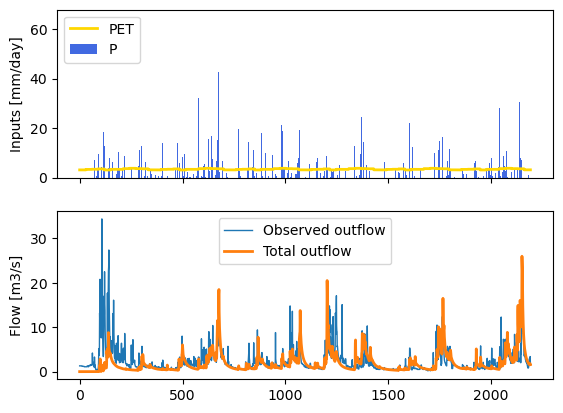

In [113]:
param = {'x1':best_params[0],
         'x2':best_params[1],
         'x3':best_params[2],
         'x4':best_params[3],
         'alpha':2.0,
         'beta':5.0,
         'gamma':5.0,
         'omega':3.5,
         'ni':4/9,
         'div':0.9}

init = {'ps':best_params[4],
        'rs':best_params[4]}

# set up and run model
model = gr4j(param, init)
model.set_input([E, P])
model.set_timestep(1.0), 
model.reset_states()

output = model.get_output()

# Plot
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].bar(x=np.arange(len(P)), height=P, color='royalblue', label='P')
ax[0].plot(np.arange(len(P)), E, lw=2, color='gold', label='PET')
ax[0].legend()
ax[0].set_ylabel('Inputs [mm/day]')

ax[1].plot(np.arange(len(P)), obs, lw=1, label='Observed outflow')
ax[1].plot(np.arange(len(P)), output[0] * A * (1/(60*60*24)) * (1/1000) * (1000)**2, lw=2, label='Total outflow')
ax[1].legend()
ax[1].set_ylabel('Flow [m3/s]')

plt.show()

In [114]:
best_params

array([ 20.00145872,   3.15956108, 368.7155252 ,   1.82411185,
         6.75994038])